In [1]:
# Cell 1: Install required libraries (CPU-based with GPU XGBoost)
!pip install xgboost scikit-learn matplotlib seaborn pandas numpy

In [2]:
# Cell 2: Imports with XGBoost GPU acceleration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available for XGBoost
import subprocess
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    gpu_available = result.returncode == 0
    print(f"GPU available for XGBoost: {gpu_available}")
except:
    gpu_available = False
    print("GPU not available - using CPU")

GPU available for XGBoost: True


In [3]:
# Cell 3: Load and preprocess the dataset
df = pd.read_csv("student_performance_large_dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Remove Student_ID and handle missing values
df = df.drop(columns=["Student_ID"], errors='ignore')
df = df.dropna()

# Display basic info
print(f"\nAfter preprocessing shape: {df.shape}")
print(f"Target distribution:\n{df['Final_Grade'].value_counts()}")

# Encode categorical variables
label_encoders = {}
categorical_cols = [
    'Gender', 'Preferred_Learning_Style', 'Participation_in_Discussions',
    'Use_of_Educational_Tech', 'Self_Reported_Stress_Level', 'Final_Grade'
]

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {le.classes_}")

Dataset shape: (10000, 15)
Columns: ['Student_ID', 'Age', 'Gender', 'Study_Hours_per_Week', 'Preferred_Learning_Style', 'Online_Courses_Completed', 'Participation_in_Discussions', 'Assignment_Completion_Rate (%)', 'Exam_Score (%)', 'Attendance_Rate (%)', 'Use_of_Educational_Tech', 'Self_Reported_Stress_Level', 'Time_Spent_on_Social_Media (hours/week)', 'Sleep_Hours_per_Night', 'Final_Grade']
Missing values: 0

After preprocessing shape: (10000, 14)
Target distribution:
Final_Grade
A    2678
B    2455
C    2440
D    2427
Name: count, dtype: int64
Encoded Gender: ['Female' 'Male' 'Other']
Encoded Preferred_Learning_Style: ['Auditory' 'Kinesthetic' 'Reading/Writing' 'Visual']
Encoded Participation_in_Discussions: ['No' 'Yes']
Encoded Use_of_Educational_Tech: ['No' 'Yes']
Encoded Self_Reported_Stress_Level: ['High' 'Low' 'Medium']
Encoded Final_Grade: ['A' 'B' 'C' 'D']


In [4]:
# Cell 4: Feature selection and data preparation
include_exam_score = True  # Set to False to exclude exam score

if include_exam_score:
    features = [col for col in df.columns if col != 'Final_Grade']
    print("Including Exam_Score in features")
else:
    features = [col for col in df.columns if col not in ['Final_Grade', 'Exam_Score']]
    print("Excluding Exam_Score from features")

X = df[features]
y = df['Final_Grade']

print(f"Features used: {features}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("Data prepared for modeling")

Including Exam_Score in features
Features used: ['Age', 'Gender', 'Study_Hours_per_Week', 'Preferred_Learning_Style', 'Online_Courses_Completed', 'Participation_in_Discussions', 'Assignment_Completion_Rate (%)', 'Exam_Score (%)', 'Attendance_Rate (%)', 'Use_of_Educational_Tech', 'Self_Reported_Stress_Level', 'Time_Spent_on_Social_Media (hours/week)', 'Sleep_Hours_per_Night']
Feature matrix shape: (10000, 13)
Target shape: (10000,)
Data prepared for modeling


In [5]:
# Cell 5: Define 8 classification models with optimized parameters
# Configure XGBoost for GPU if available
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

if gpu_available:
    xgb_params['tree_method'] = 'gpu_hist'
    xgb_params['gpu_id'] = 0
    xgb_label = 'Gradient Boosting (GPU)'
else:
    xgb_params['tree_method'] = 'hist'
    xgb_label = 'Gradient Boosting (CPU)'

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Naive Bayes': MultinomialNB(),
    'k-NN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'SVM': SVC(probability=True, random_state=42, kernel='rbf'),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ),
    xgb_label: XGBClassifier(**xgb_params)
}

print(f" Models defined - XGBoost using: {'GPU' if gpu_available else 'CPU'}")

 Models defined - XGBoost using: GPU


In [6]:
# Cell 6: 5-Fold Cross-validation with comprehensive metrics
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(" Starting 5-fold cross-validation...\n")

for name, model in models.items():
    print(f" Training: {name}")
    
    fold_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'mcc': [],
        'auc': []
    }
    
    fold_num = 1
    for train_idx, test_idx in skf.split(X, y):
        print(f"  Fold {fold_num}/5", end=" ")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        try:
            # Train model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Get probabilities for AUC
            if hasattr(model, 'predict_proba'):
                y_prob = model.predict_proba(X_test)
            else:
                y_prob = None
            
            # Calculate metrics
            fold_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            fold_metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
            fold_metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
            fold_metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
            fold_metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
            
            # Calculate AUC for multiclass
            if y_prob is not None:
                try:
                    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
                    fold_metrics['auc'].append(auc)
                except:
                    fold_metrics['auc'].append(0.0)
            else:
                fold_metrics['auc'].append(0.0)
                
            print("✓")
            
        except Exception as e:
            print(f"✗ Error: {str(e)[:50]}...")
            # Fill with zeros for failed folds
            for metric in fold_metrics:
                fold_metrics[metric].append(0.0)
        
        fold_num += 1
    
    # Calculate mean metrics across folds
    mean_metrics = {metric: np.mean(values) for metric, values in fold_metrics.items()}
    std_metrics = {metric: np.std(values) for metric, values in fold_metrics.items()}
    
    results.append({
        'Model': name,
        'Accuracy': mean_metrics['accuracy'],
        'Accuracy_Std': std_metrics['accuracy'],
        'F1 Score': mean_metrics['f1'],
        'F1_Std': std_metrics['f1'],
        'Precision': mean_metrics['precision'],
        'Precision_Std': std_metrics['precision'],
        'Recall': mean_metrics['recall'],
        'Recall_Std': std_metrics['recall'],
        'MCC': mean_metrics['mcc'],
        'MCC_Std': std_metrics['mcc'],
        'AUC': mean_metrics['auc'],
        'AUC_Std': std_metrics['auc']
    })
    
    print(f" Accuracy: {mean_metrics['accuracy']:.4f} ± {std_metrics['accuracy']:.4f}")

# Create results dataframe and sort by accuracy
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\n Cross-validation completed!")

 Starting 5-fold cross-validation...

 Training: Logistic Regression
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 0.8784 ± 0.0276
 Training: Decision Tree
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 1.0000 ± 0.0000
 Training: Random Forest
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 1.0000 ± 0.0000
 Training: Naive Bayes
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 0.6813 ± 0.0047
 Training: k-NN
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 0.9101 ± 0.0039
 Training: SVM
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 0.9969 ± 0.0016
 Training: Neural Network
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 0.8120 ± 0.0354
 Training: Gradient Boosting (GPU)
  Fold 1/5 ✓
  Fold 2/5 ✓
  Fold 3/5 ✓
  Fold 4/5 ✓
  Fold 5/5 ✓
 Accuracy: 1.0000 ± 0.0000

 Cross-validation completed!


In [7]:
# Cell 7: Display comprehensive results table
print(" MODEL PERFORMANCE RANKING")

display_df = results_df[['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'AUC']].copy()
display_df = display_df.round(4)

for i, row in display_df.iterrows():
    print(f"{row['Model']:<25} | Acc: {row['Accuracy']:.4f} | F1: {row['F1 Score']:.4f} | "
          f"Prec: {row['Precision']:.4f} | Rec: {row['Recall']:.4f} | MCC: {row['MCC']:.4f} | AUC: {row['AUC']:.4f}")


 MODEL PERFORMANCE RANKING
Decision Tree             | Acc: 1.0000 | F1: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | MCC: 1.0000 | AUC: 1.0000
Random Forest             | Acc: 1.0000 | F1: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | MCC: 1.0000 | AUC: 1.0000
Gradient Boosting (GPU)   | Acc: 1.0000 | F1: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | MCC: 1.0000 | AUC: 1.0000
SVM                       | Acc: 0.9969 | F1: 0.9969 | Prec: 0.9969 | Rec: 0.9969 | MCC: 0.9959 | AUC: 1.0000
k-NN                      | Acc: 0.9101 | F1: 0.9101 | Prec: 0.9105 | Rec: 0.9101 | MCC: 0.8802 | AUC: 0.9884
Logistic Regression       | Acc: 0.8784 | F1: 0.8783 | Prec: 0.8785 | Rec: 0.8784 | MCC: 0.8378 | AUC: 0.9804
Neural Network            | Acc: 0.8120 | F1: 0.8106 | Prec: 0.8134 | Rec: 0.8120 | MCC: 0.7504 | AUC: 0.9630
Naive Bayes               | Acc: 0.6813 | F1: 0.6805 | Prec: 0.6804 | Rec: 0.6813 | MCC: 0.5749 | AUC: 0.9010


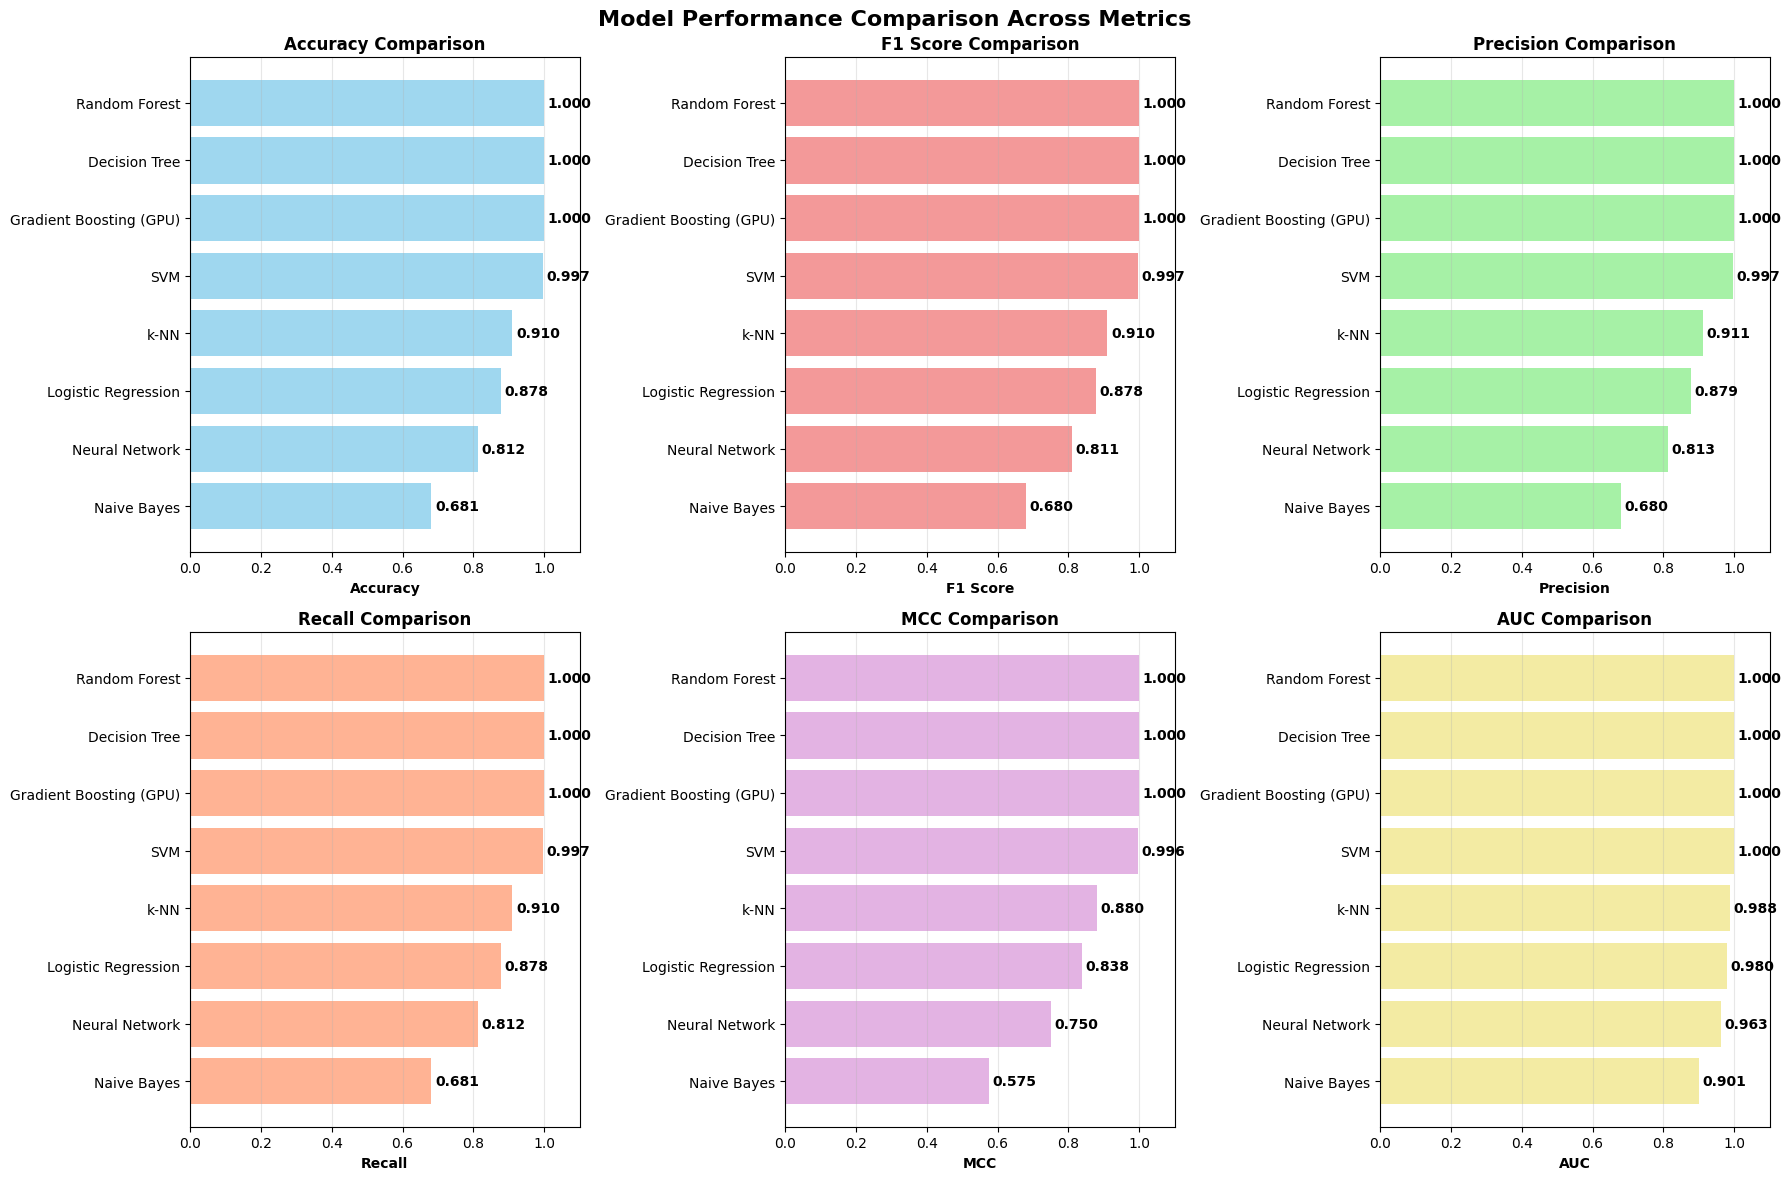

In [8]:
# Cell 8: Visualization - Performance comparison
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison Across Metrics', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'plum', 'khaki']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    sorted_df = results_df.sort_values(by=metric, ascending=True)
    bars = ax.barh(range(len(sorted_df)), sorted_df[metric], color=colors[idx], alpha=0.8)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Model'], fontsize=10)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

 CONFUSION MATRICES FOR TOP 3 MODELS

 Decision Tree
  Accuracy: 1.0000

 Random Forest
  Accuracy: 1.0000

 Gradient Boosting (GPU)
  Accuracy: 1.0000


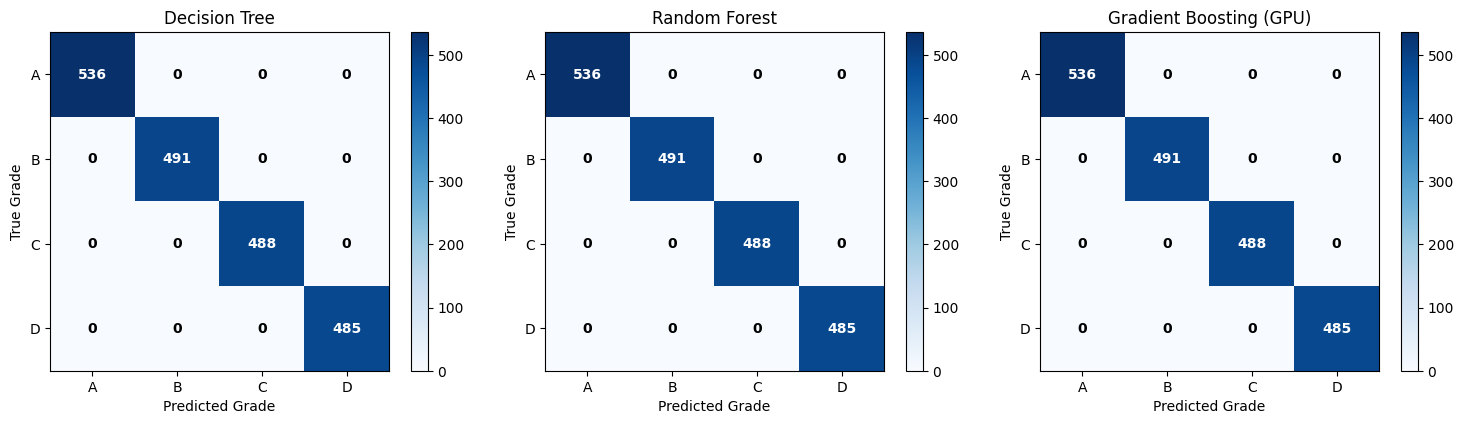

In [9]:
# Cell 9: Confusion matrices for top 3 models
print(" CONFUSION MATRICES FOR TOP 3 MODELS")

top3_models = results_df.head(3)['Model'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, model_name in enumerate(top3_models):
    model = models[model_name]
    print(f"\n {model_name}")
    
    try:
        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        ax = axes[idx]
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        ax.figure.colorbar(im, ax=ax)
        
        # Add labels
        classes = label_encoders['Final_Grade'].classes_
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes,
               yticklabels=classes,
               title=model_name,
               ylabel='True Grade',
               xlabel='Predicted Grade')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontweight='bold')
        
        # Calculate and display accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"  Accuracy: {acc:.4f}")
        
    except Exception as e:
        print(f"   Error: {e}")
        axes[idx].text(0.5, 0.5, f"Error:\n{str(e)[:30]}...", 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"{model_name} - Error")

plt.tight_layout()
plt.show()

 FEATURE IMPORTANCE ANALYSIS

Decision Tree - Top 3 Important Features:
  Self_Reported_Stress_Level: 0.0000
  Time_Spent_on_Social_Media (hours/week): 0.0000
  Exam_Score (%): 1.0000

Random Forest - Top 3 Important Features:
  Assignment_Completion_Rate (%): 0.0205
  Attendance_Rate (%): 0.0209
  Exam_Score (%): 0.8488

Gradient Boosting (GPU) - Top 3 Important Features:
  Time_Spent_on_Social_Media (hours/week): 0.0000
  Sleep_Hours_per_Night: 0.0000
  Exam_Score (%): 1.0000


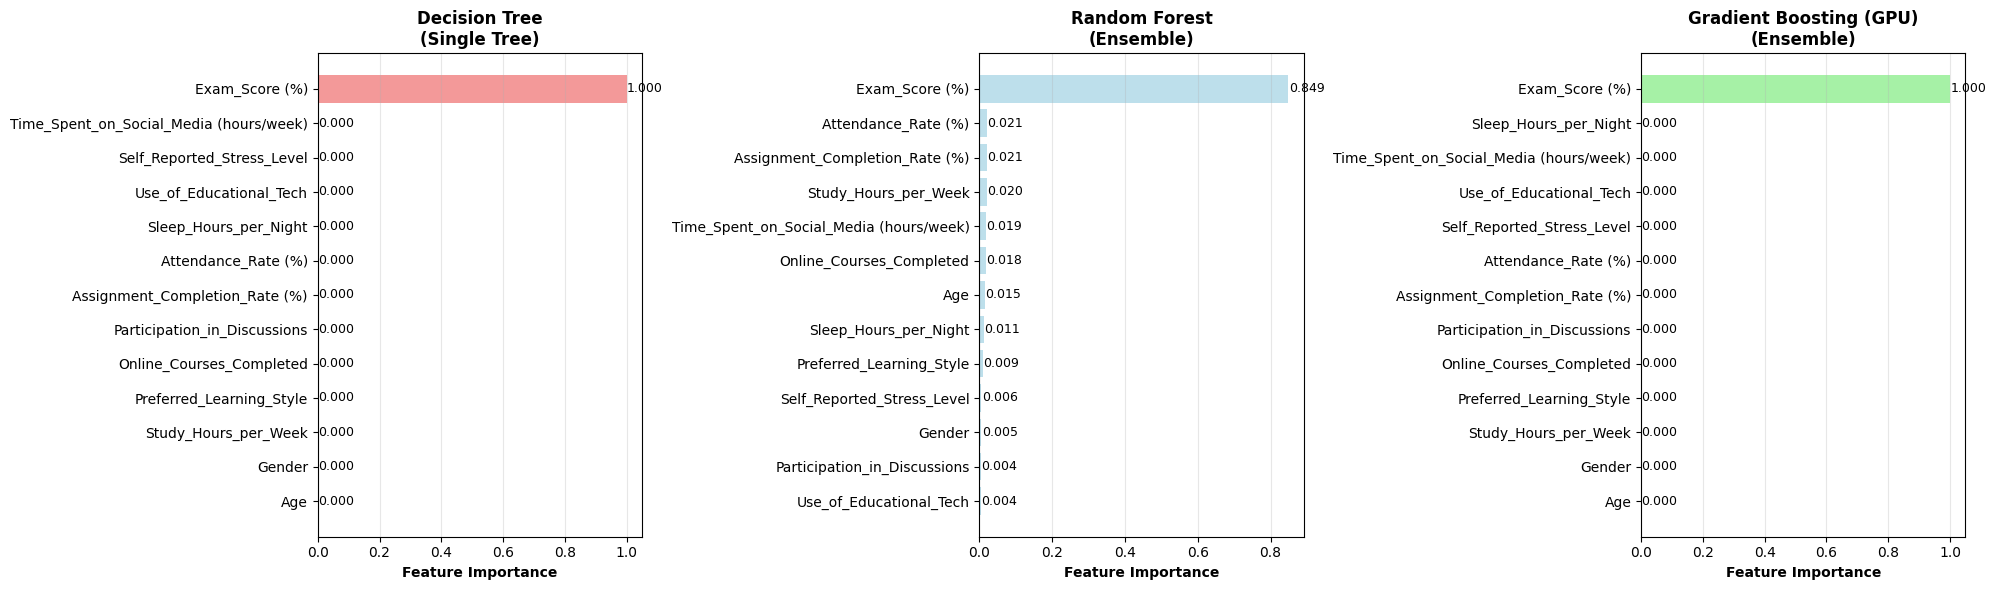


📊 FEATURE IMPORTANCE COMPARISON
Feature importance comparison across tree-based models:
                                         Decision Tree  Random Forest  \
Exam_Score (%)                                     1.0         0.8488   
Gender                                             0.0         0.0054   
Study_Hours_per_Week                               0.0         0.0203   
Preferred_Learning_Style                           0.0         0.0086   
Age                                                0.0         0.0147   
Online_Courses_Completed                           0.0         0.0175   
Participation_in_Discussions                       0.0         0.0041   
Assignment_Completion_Rate (%)                     0.0         0.0205   
Attendance_Rate (%)                                0.0         0.0209   
Use_of_Educational_Tech                            0.0         0.0036   
Self_Reported_Stress_Level                         0.0         0.0057   
Time_Spent_on_Social_Media (hours/w

In [10]:
# Cell 10: Enhanced Feature importance analysis 
print(" FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Include all tree-based models
feature_importance_models = ['Decision Tree', 'Random Forest', xgb_label]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  

for idx, model_name in enumerate(feature_importance_models):
    if model_name in models:
        model = models[model_name]
        
        try:
            # Train the model on full dataset
            model.fit(X, y)
            
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue
            
            # Create DataFrame for plotting
            feature_imp_df = pd.DataFrame({
                'feature': features,
                'importance': importances
            }).sort_values('importance', ascending=True)
            
            # Plot
            ax = axes[idx]
            # Different colors for different model types
            colors = ['lightcoral', 'lightblue', 'lightgreen']
            bars = ax.barh(range(len(feature_imp_df)), feature_imp_df['importance'], 
                          color=colors[idx], alpha=0.8)
            
            # Add value labels
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                       f'{width:.3f}', ha='left', va='center', fontsize=9)
            
            ax.set_yticks(range(len(feature_imp_df)))
            ax.set_yticklabels(feature_imp_df['feature'], fontsize=10)
            ax.set_xlabel('Feature Importance', fontweight='bold')
            
            # Add model type indicator
            model_type = "Single Tree" if model_name == "Decision Tree" else "Ensemble"
            ax.set_title(f'{model_name}\n({model_type})', fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            print(f"\n{model_name} - Top 3 Important Features:")
            top_features = feature_imp_df.tail(3)
            for _, row in top_features.iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
                
        except Exception as e:
            print(f" Could not get feature importance for {model_name}: {e}")
            axes[idx].text(0.5, 0.5, f"Feature importance\nnot available", 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f"{model_name} - N/A")

plt.tight_layout()
plt.show()

# Compare feature rankings across models
print("\n📊 FEATURE IMPORTANCE COMPARISON")
comparison_data = {}
for model_name in feature_importance_models:
    if model_name in models:
        model = models[model_name]
        model.fit(X, y)
        if hasattr(model, 'feature_importances_'):
            comparison_data[model_name] = dict(zip(features, model.feature_importances_))

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data).round(4)
    print("Feature importance comparison across tree-based models:")
    print(comparison_df.sort_values(by=list(comparison_data.keys())[0], ascending=False))

In [11]:
# Cell 11: Export results and summary with table display
import os
import time

# Save detailed results with error handling
try:
    # Try to save the CSV file
    filename = f"model_comparison_results_{int(time.time())}.csv"
    results_df.to_csv(filename, index=False)
    print(f" Detailed results exported to '{filename}'")
except PermissionError:
    print(" Could not save CSV file (file may be open in another program)")
    print(" Displaying results in console instead")

# Display results in table format
print("\n DETAILED MODEL COMPARISON RESULTS")
print("=" * 120)

# Create a formatted table with all metrics
display_columns = ['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'AUC']
table_df = results_df[display_columns].copy()

# Round values for display
table_df.iloc[:, 1:] = table_df.iloc[:, 1:].round(4)

# Print table header
header = f"{'Rank':<4} | {'Model':<25} | {'Accuracy':<8} | {'F1 Score':<8} | {'Precision':<9} | {'Recall':<8} | {'MCC':<8} | {'AUC':<8}"
print(header)
print("-" * len(header))

# Print table rows
for rank, (idx, row) in enumerate(table_df.iterrows(), 1):
    print(f"{rank:<4} | {row['Model']:<25} | {row['Accuracy']:<8.4f} | {row['F1 Score']:<8.4f} | "
          f"{row['Precision']:<9.4f} | {row['Recall']:<8.4f} | {row['MCC']:<8.4f} | {row['AUC']:<8.4f}")

print("=" * 120)

# Display standard deviations table
print("\n STANDARD DEVIATIONS (Cross-Validation Stability)")
print("=" * 120)

std_columns = ['Model', 'Accuracy_Std', 'F1_Std', 'Precision_Std', 'Recall_Std', 'MCC_Std', 'AUC_Std']
std_df = results_df[std_columns].copy()
std_df.iloc[:, 1:] = std_df.iloc[:, 1:].round(4)

# Print std table header
std_header = f"{'Rank':<4} | {'Model':<25} | {'Acc Std':<8} | {'F1 Std':<8} | {'Prec Std':<9} | {'Rec Std':<8} | {'MCC Std':<8} | {'AUC Std':<8}"
print(std_header)
print("-" * len(std_header))

# Print std table rows
for rank, (idx, row) in enumerate(std_df.iterrows(), 1):
    print(f"{rank:<4} | {row['Model']:<25} | {row['Accuracy_Std']:<8.4f} | {row['F1_Std']:<8.4f} | "
          f"{row['Precision_Std']:<9.4f} | {row['Recall_Std']:<8.4f} | {row['MCC_Std']:<8.4f} | {row['AUC_Std']:<8.4f}")

print("=" * 120)

# Create summary report
summary_report = f"""
EDUCATIONAL SUCCESS PREDICTION - MODEL COMPARISON REPORT

Dataset Information:
- Total samples: {len(df)}
- Features used: {len(features)}
- Target classes: {len(label_encoders['Final_Grade'].classes_)}
- Exam score included: {include_exam_score}

Top 3 Performing Models:
"""

for i, (_, row) in enumerate(results_df.head(3).iterrows(), 1):
    summary_report += f"""
{i}. {row['Model']}
   - Accuracy: {row['Accuracy']:.4f} ± {row['Accuracy_Std']:.4f}
   - F1 Score: {row['F1 Score']:.4f} ± {row['F1_Std']:.4f}
   - Precision: {row['Precision']:.4f} ± {row['Precision_Std']:.4f}
   - Recall: {row['Recall']:.4f} ± {row['Recall_Std']:.4f}
   - MCC: {row['MCC']:.4f} ± {row['MCC_Std']:.4f}
   - AUC: {row['AUC']:.4f} ± {row['AUC_Std']:.4f}
"""

# Add complete results table to summary
summary_report += f"""

COMPLETE MODEL COMPARISON TABLE:
{'='*60}
{'Rank':<4} | {'Model':<25} | {'Accuracy':<8} | {'F1':<8} | {'Precision':<9} | {'Recall':<8} | {'MCC':<8} | {'AUC':<8}
{'-'*120}
"""

for rank, (idx, row) in enumerate(table_df.iterrows(), 1):
    summary_report += f"""
{rank:<4} | {row['Model']:<25} | {row['Accuracy']:<8.4f} | {row['F1 Score']:<8.4f} | {row['Precision']:<9.4f} | {row['Recall']:<8.4f} | {row['MCC']:<8.4f} | {row['AUC']:<8.4f}"""

summary_report += f"""

Processing Configuration:
- GPU Available: {gpu_available}
- XGBoost using: {'GPU acceleration' if gpu_available else 'CPU processing'}
- Parallel processing: Enabled for compatible models

Analysis Notes:
- Cross-validation: 5-fold stratified
- Evaluation metrics: 6 comprehensive metrics
- Feature encoding: Label encoding for categorical variables
- Missing values: Removed ({df.shape[0]} samples retained)

Best Performing Model: {results_df.iloc[0]['Model']} (Accuracy: {results_df.iloc[0]['Accuracy']:.4f})
Most Stable Model: {results_df.loc[results_df['Accuracy_Std'].idxmin(), 'Model']} (Std: {results_df['Accuracy_Std'].min():.4f})
"""

# Save summary report with error handling
try:
    summary_filename = f"model_analysis_summary_{int(time.time())}.txt"
    with open(summary_filename, "w") as f:
        f.write(summary_report)
    print(f" Summary report exported to '{summary_filename}'")
except PermissionError:
    print(" Could not save summary file")

# Display the summary report
print("\n" + summary_report)

# Display key insights
print("\n KEY INSIGHTS")
print("=" * 50)
best_model = results_df.iloc[0]
most_stable = results_df.loc[results_df['Accuracy_Std'].idxmin()]

print(f" Best Overall Performance: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f} ± {best_model['Accuracy_Std']:.4f}")
print(f" Most Stable Model: {most_stable['Model']}")
print(f"   Std Dev: {most_stable['Accuracy_Std']:.4f}")
print(f" Performance Range: {results_df['Accuracy'].min():.4f} - {results_df['Accuracy'].max():.4f}")
print(f" GPU Acceleration: {'Enabled' if gpu_available else 'Disabled'}")

# Display results as DataFrame for easy viewing
print("\n RESULTS DATAFRAME")
print("=" * 50)
display(results_df[['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'AUC']].round(4))

 Detailed results exported to 'model_comparison_results_1751184119.csv'

 DETAILED MODEL COMPARISON RESULTS
Rank | Model                     | Accuracy | F1 Score | Precision | Recall   | MCC      | AUC     
---------------------------------------------------------------------------------------------------
1    | Decision Tree             | 1.0000   | 1.0000   | 1.0000    | 1.0000   | 1.0000   | 1.0000  
2    | Random Forest             | 1.0000   | 1.0000   | 1.0000    | 1.0000   | 1.0000   | 1.0000  
3    | Gradient Boosting (GPU)   | 1.0000   | 1.0000   | 1.0000    | 1.0000   | 1.0000   | 1.0000  
4    | SVM                       | 0.9969   | 0.9969   | 0.9969    | 0.9969   | 0.9959   | 1.0000  
5    | k-NN                      | 0.9101   | 0.9101   | 0.9105    | 0.9101   | 0.8802   | 0.9884  
6    | Logistic Regression       | 0.8784   | 0.8783   | 0.8785    | 0.8784   | 0.8378   | 0.9804  
7    | Neural Network            | 0.8120   | 0.8106   | 0.8134    | 0.8120   | 0.7504   | 0

,Model,Accuracy,F1 Score,Precision,Recall,MCC,AUC
1,Decision Tree,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,Gradient Boosting (GPU),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,SVM,0.9969,0.9969,0.9969,0.9969,0.9959,1.0000
4,k-NN,0.9101,0.9101,0.9105,0.9101,0.8802,0.9884
0,Logistic Regression,0.8784,0.8783,0.8785,0.8784,0.8378,0.9804
6,Neural Network,0.8120,0.8106,0.8134,0.8120,0.7504,0.9630
3,Naive Bayes,0.6813,0.6805,0.6804,0.6813,0.5749,0.9010


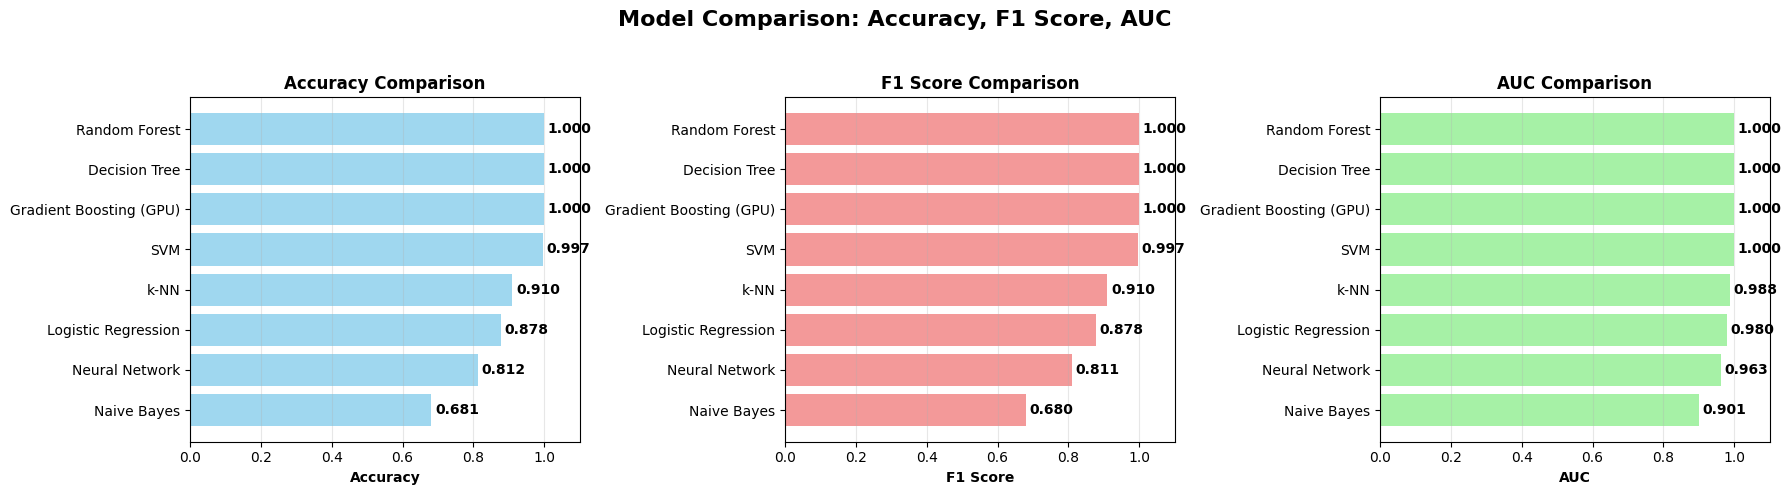

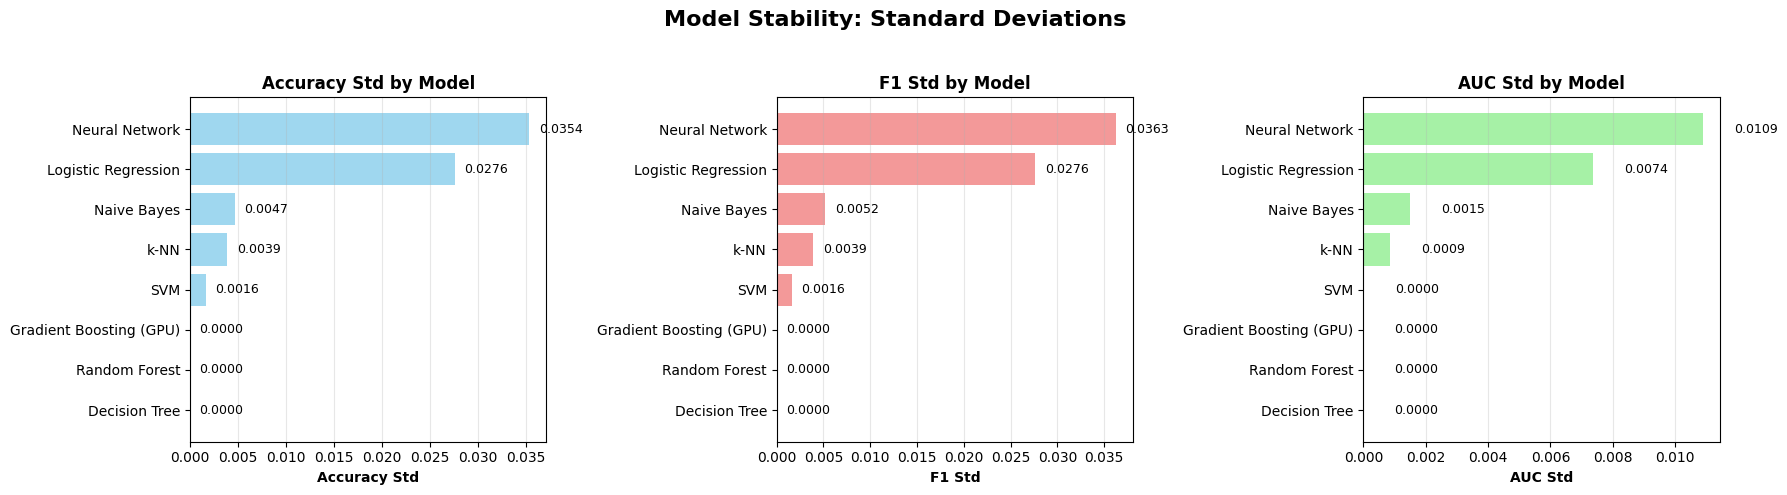


 FEATURE IMPORTANCE SUMMARY (Tree-Based Models)


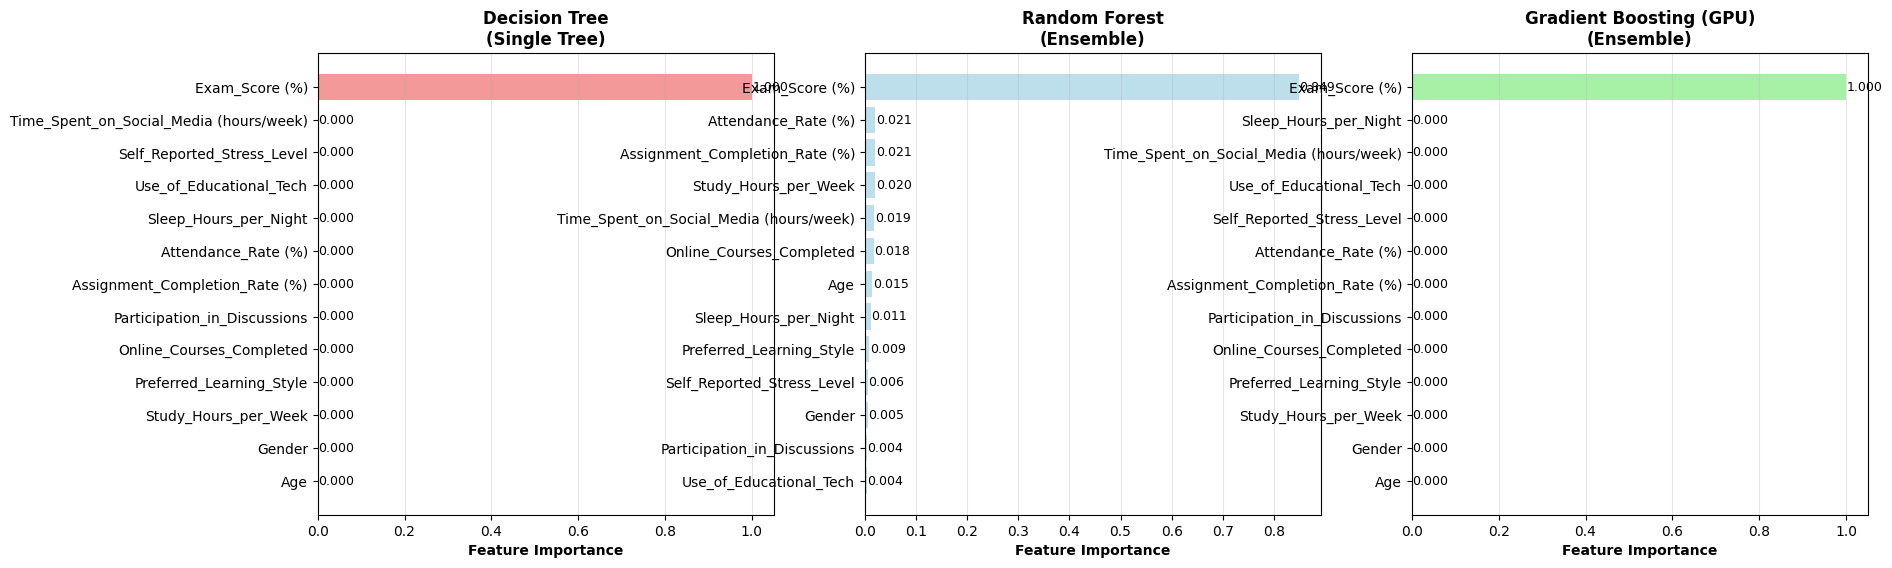

In [12]:
# Cell 12: AUC, Accuracy, F1 comparison bar plots
import matplotlib.pyplot as plt

metrics_to_plot = ['Accuracy', 'F1 Score', 'AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Comparison: Accuracy, F1 Score, AUC', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    sorted_df = results_df.sort_values(by=metric, ascending=True)
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=colors[idx], alpha=0.8)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center', fontweight='bold')
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.grid(axis='x', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📈 Standard deviation plots (if available)
std_metrics = ['Accuracy_Std', 'F1_Std', 'AUC_Std']
std_labels = ['Accuracy Std', 'F1 Std', 'AUC Std']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Stability: Standard Deviations', fontsize=16, fontweight='bold')

for idx, (std_metric, std_label) in enumerate(zip(std_metrics, std_labels)):
    ax = axes[idx]
    sorted_df = results_df.sort_values(by=std_metric, ascending=True)
    bars = ax.barh(sorted_df['Model'], sorted_df[std_metric], color=colors[idx], alpha=0.8)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.4f}', ha='left', va='center', fontsize=9)
    ax.set_xlabel(std_label, fontweight='bold')
    ax.set_title(f'{std_label} by Model', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Feature importance visualizations (summary)
print("\n FEATURE IMPORTANCE SUMMARY (Tree-Based Models)")
feature_importance_models = ['Decision Tree', 'Random Forest', xgb_label]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, model_name in enumerate(feature_importance_models):
    if model_name in models:
        model = models[model_name]
        try:
            model.fit(X, y)
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue
            feature_imp_df = pd.DataFrame({
                'feature': features,
                'importance': importances
            }).sort_values('importance', ascending=True)
            ax = axes[idx]
            colors2 = ['lightcoral', 'lightblue', 'lightgreen']
            bars = ax.barh(feature_imp_df['feature'], feature_imp_df['importance'], color=colors2[idx], alpha=0.8)
            for bar in bars:
                width = bar.get_width()
                ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center', fontsize=9)
            ax.set_xlabel('Feature Importance', fontweight='bold')
            model_type = "Single Tree" if model_name == "Decision Tree" else "Ensemble"
            ax.set_title(f'{model_name}\n({model_type})', fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
        except Exception as e:
            print(f" Could not get feature importance for {model_name}: {e}")
            axes[idx].text(0.5, 0.5, f"Feature importance\nnot available", ha='center', va='center', transform=axes[idx].transAxes)